In [63]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'serif'

In [64]:
# Load demand and capacity factor data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0)
df_elec.index = pd.to_datetime(df_elec.index)
country = 'GBR'

In [65]:
def annuity(n, r):
    return r / (1 - 1 / (1 + r)**n) if r > 0 else 1 / n

In [66]:
def build_network_with_co2_limit(co2_limit_tonnes):
    network = pypsa.Network()
    network.set_snapshots(pd.date_range('2015-01-01 00:00', '2015-12-31 23:00', freq='h'))

    network.add("Bus", "electricity bus", carrier="electricity")
    network.add("Load", "load", bus="electricity bus", p_set=df_elec[country].values)

    # Technology and cost assumptions
    techs = {
        "onshorewind": {"capex": 1.4e6, "lifetime": 25, "carrier": "onshorewind"},
        "offshorewind": {"capex": 2.8e6, "lifetime": 25, "carrier": "offshorewind"},
        "solar": {"capex": 628e3, "lifetime": 25, "carrier": "solar"},
        "nuclear": {"capex": 11.08e6, "fuel_cost": 6.2, "eff": 0.33, "lifetime": 40, "carrier": "nuclear"},
        "CCGT": {"capex": 1.04e6, "fuel_cost": 30.32, "eff": 0.5, "lifetime": 30, "carrier": "gas"}
    }

    # Add carriers
    network.add("Carrier", "gas", co2_emissions=0.2019)  # in tCO₂/MWh_th
    for tech in ["onshorewind", "offshorewind", "solar", "nuclear"]:
        network.add("Carrier", tech)

    # Capacity factors
    df_cf = {
        "onshorewind": pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0),
        "offshorewind": pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0),
        "solar": pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    }
    for key in df_cf:
        df_cf[key].index = pd.to_datetime(df_cf[key].index)

    for tech, params in techs.items():
        if tech in ["onshorewind", "offshorewind", "solar"]:
            cf = df_cf[tech][country][[snap.strftime("%Y-%m-%dT%H:%M:%SZ") for snap in network.snapshots]].values
            cap_cost = annuity(params["lifetime"], 0.07) * params["capex"] * 1.03
            network.add("Generator",
                        tech,
                        bus="electricity bus",
                        p_nom_extendable=True,
                        carrier=params["carrier"],
                        capital_cost=cap_cost,
                        marginal_cost=0,
                        p_max_pu=cf)
        else:
            fuel_cost = params["fuel_cost"]
            eff = params["eff"]
            cap_cost = annuity(params["lifetime"], 0.07) * (params["capex"] + 14.32 * 1000)
            marginal_cost = fuel_cost / eff
            network.add("Generator",
                        tech,
                        bus="electricity bus",
                        p_nom_extendable=True,
                        carrier=params["carrier"],
                        capital_cost=cap_cost,
                        marginal_cost=marginal_cost)

    # Add CO₂ constraint
    network.add("GlobalConstraint",
                "co2_limit",
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit_tonnes)

        # Solve
    network.optimize(solver_name='gurobi', solver_options={"LogToConsole": 0})

    return network


In [67]:
# RUN MODEL FOR SPECIFIC CO₂ TARGET
co2_target = 30e6  # 30 MtCO₂/year
network_E = build_network_with_co2_limit(co2_target)

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 25.39it/s]
INFO:linopy.io: Writing time: 0.81s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-6urfiwct.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-6urfiwct.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x3a169e2d
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 3e+07]
INFO:gurobipy:Presolve removed 48051 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.28s
INFO:gurobipy:Presolved: 48315 rows, 39559 columns, 127422 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

In [68]:
# Extract and Print CO₂ Price
co2_price = -network_E.global_constraints.mu['co2_limit']  # €/tCO₂
print(f"Model-derived CO₂ price to reach {co2_target:.0e} tCO₂/year limit: {co2_price:.2f} €/tCO₂")

Model-derived CO₂ price to reach 3e+07 tCO₂/year limit: 39.26 €/tCO₂


In [69]:
# Compare with UK ETS as of 2025
uk_ets_price_range = (47, 58)  # €/tCO₂ (approx from £40–£50/tCO₂)
print(f"UK ETS 2025 market range: {uk_ets_price_range[0]}–{uk_ets_price_range[1]} €/tCO₂")
if co2_price < uk_ets_price_range[0]:
    print("→ The required CO₂ price is below the current market range. Market-based CO₂ pricing could already incentivize this decarbonization level.")
elif co2_price > uk_ets_price_range[1]:
    print("→ The required CO₂ price is above the UK ETS range. Stronger CO₂ policy or complementary measures may be needed.")
else:
    print("→ The required CO₂ price is within the UK ETS range. The market is aligned with this target.")

UK ETS 2025 market range: 47–58 €/tCO₂
→ The required CO₂ price is below the current market range. Market-based CO₂ pricing could already incentivize this decarbonization level.


/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/ipykernel_58952/1646346164.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sample_hours = pd.date_range("2015-01-01", periods=168, freq='H')  # one week


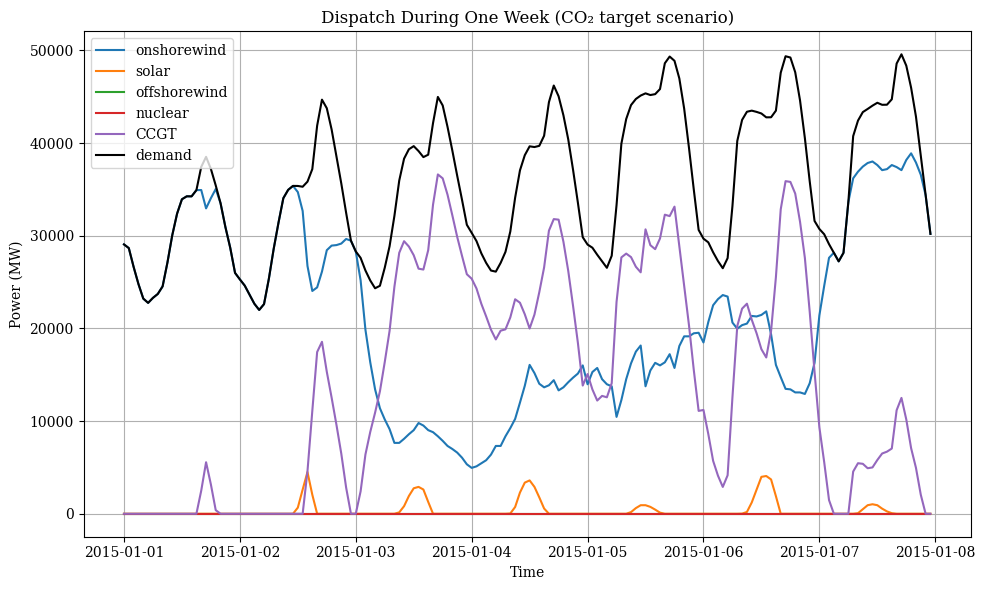

In [70]:
# Visualize hourly dispatch for a sample week
sample_hours = pd.date_range("2015-01-01", periods=168, freq='H')  # one week
plt.figure(figsize=(10, 6))
for tech in ["onshorewind", "solar", "offshorewind", "nuclear", "CCGT"]:
    plt.plot(network_E.generators_t.p[tech][sample_hours], label=tech)
plt.plot(network_E.loads_t.p['load'][sample_hours], label='demand', color='black')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.title("Dispatch During One Week (CO₂ target scenario)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
# Sensitivity Analysis: CO₂ Prices for Multiple Targets
co2_limits_list = [60e6, 45e6, 30e6, 15e6, 5e6, 1e6]  # in tCO₂/year
co2_prices = []
total_costs = []

for limit in co2_limits_list:
    net = build_network_with_co2_limit(limit)
    co2_prices.append(-net.global_constraints.mu['co2_limit'])
    capex = net.statistics.capex().sum() / 1e9  # bn€/year
    opex = net.statistics.opex().sum() / 1e9
    total_costs.append(capex + opex)

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 22.95it/s]
INFO:linopy.io: Writing time: 0.71s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-rege6xbr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-rege6xbr.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x09c5a950
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 6e+07]
INFO:gurobipy:Presolve removed 48052 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.21s
INFO:gurobipy:Presolved: 48314 rows, 39559 columns, 118662 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-4365wj2t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-4365wj2t.lp


Reading time = 0.27 seconds


INFO:gurobipy:Reading time = 0.27 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x56abbf8a
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 4e+07]
INFO:gurobipy:Presolve removed 48051 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.29s
INFO:gurobipy:Presolved: 48315 rows, 39559 columns, 127422 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-xy62z3n_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-xy62z3n_.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x3a169e2d
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 3e+07]
INFO:gurobipy:Presolve removed 48051 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.25s
INFO:gurobipy:Presolved: 48315 rows, 39559 columns, 127422 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-4hiq8mqx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-4hiq8mqx.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x984d0c35
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 2e+07]
INFO:gurobipy:Presolve removed 48051 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.34s
INFO:gurobipy:Presolved: 48315 rows, 39559 columns, 127422 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-l43e_xo5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-l43e_xo5.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x079fbff3
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 5e+06]
INFO:gurobipy:Presolve removed 48051 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.28s
INFO:gurobipy:Presolved: 48315 rows, 39559 columns, 127422 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2659440


INFO:gurobipy:Set parameter LicenseID to value 2659440


Academic license - for non-commercial use only - expires 2026-04-30


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-30


Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-jtbhr0q2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/dk/qccdw4qx5dq5wxkdgsyy_g400000gn/T/linopy-problem-jtbhr0q2.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21G531)
INFO:gurobipy:
INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 179719 nonzeros
INFO:gurobipy:Model fingerprint: 0x037862b2
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 8e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e+04, 1e+06]
INFO:gurobipy:Presolve removed 48051 rows and 4246 columns
INFO:gurobipy:Presolve time: 0.27s
INFO:gurobipy:Presolved: 48315 rows, 39559 columns, 127422 nonzeros
INFO:gurobipy:
INFO:gurobipy:Concurrent LP optimizer: dual sim

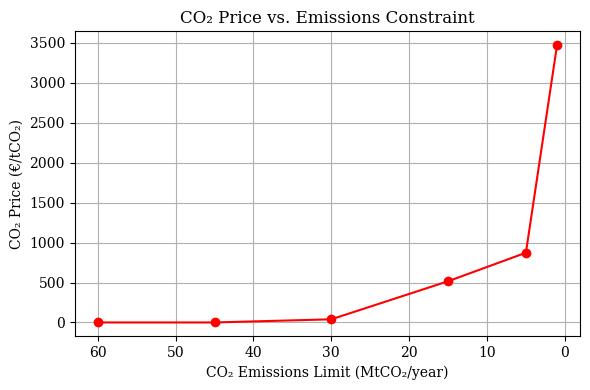

In [72]:
# Plot CO₂ price vs. emissions constraint
plt.figure(figsize=(6, 4))
plt.plot(np.array(co2_limits_list) / 1e6, co2_prices, marker='o', color='red')
plt.xlabel("CO₂ Emissions Limit (MtCO₂/year)")
plt.ylabel("CO₂ Price (€/tCO₂)")
plt.title("CO₂ Price vs. Emissions Constraint")
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

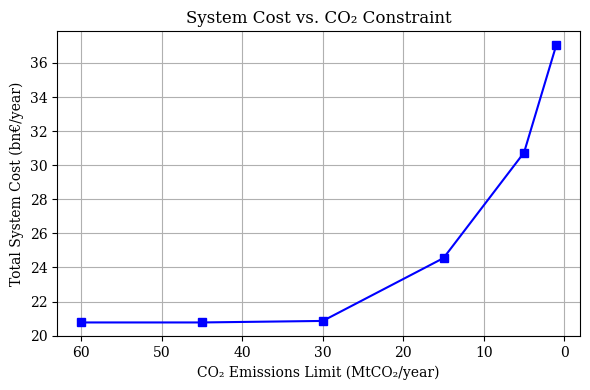

In [73]:
# Plot total cost vs. CO₂ constraint
plt.figure(figsize=(6, 4))
plt.plot(np.array(co2_limits_list) / 1e6, total_costs, marker='s', color='blue')
plt.xlabel("CO₂ Emissions Limit (MtCO₂/year)")
plt.ylabel("Total System Cost (bn€/year)")
plt.title("System Cost vs. CO₂ Constraint")
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()